/var/folders/tc/qn2wdtrd4n3c7xsgj4x5n6f80000gn/T/ipykernel_13256/941501323.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


Selected features for 7-day prediction: ['sp500_Close', 'bitcoin_Close', 'Unemployment', 'treasury_3m']
R² score for 7-day prediction: 0.9742321513156119
Mean Absolute Error (MAE): 6.354689213034928
Mean Squared Error (MSE): 73.91454179820761
Root Mean Squared Error (RMSE): 8.597356675060515


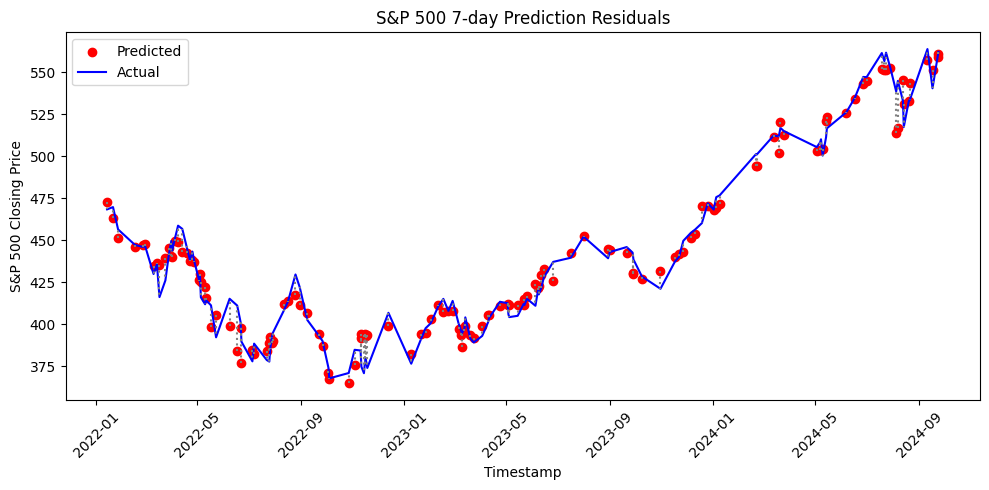

Selected features for 30-day prediction: ['sp500_Close', 'Unemployment', 'treasury_3m', 'bitcoin_Close', 'gold_Close']
R² score for 30-day prediction: 0.9888016670096222
Mean Absolute Error (MAE): 4.197295890565794
Mean Squared Error (MSE): 29.957447375481728
Root Mean Squared Error (RMSE): 5.47333969121977


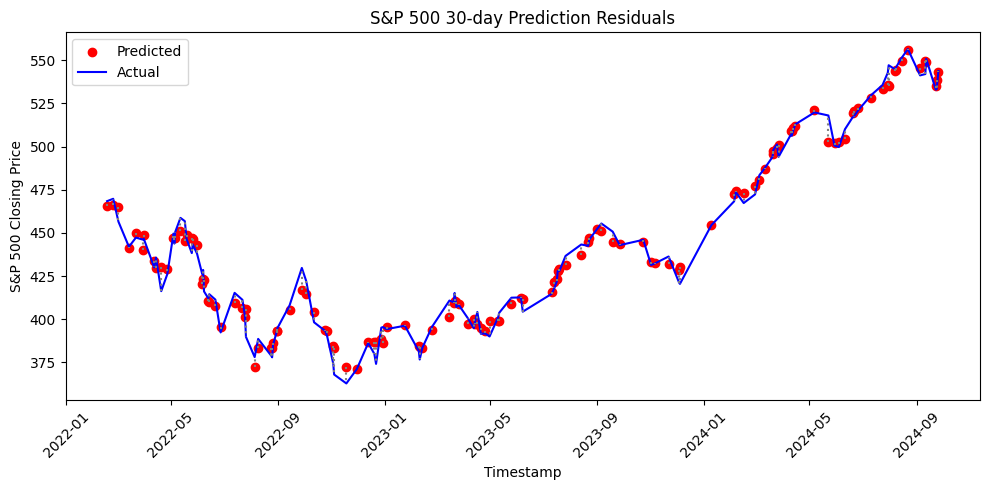

Selected features for 180-day prediction: ['bitcoin_Close', 'treasury_3m', 'sp500_Close', 'gold_Close', 'Unemployment', 'oil_price', 'Copper', 'treasury_10y']
R² score for 180-day prediction: 0.9387389116279342
Mean Absolute Error (MAE): 5.7293029981037185
Mean Squared Error (MSE): 56.67820997204034
Root Mean Squared Error (RMSE): 7.528493207278621


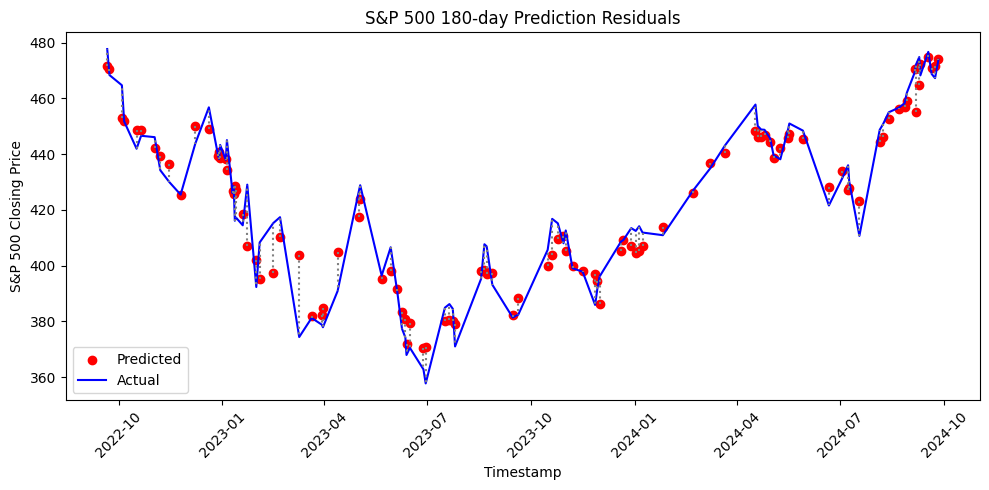

Final results: {7: {'R²': 0.9742321513156119, 'MAE': 6.354689213034928, 'MSE': 73.91454179820761, 'RMSE': np.float64(8.597356675060515)}, 30: {'R²': 0.9888016670096222, 'MAE': 4.197295890565794, 'MSE': 29.957447375481728, 'RMSE': np.float64(5.47333969121977)}, 180: {'R²': 0.9387389116279342, 'MAE': 5.7293029981037185, 'MSE': 56.67820997204034, 'RMSE': np.float64(7.528493207278621)}}


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# Load merged dataset with oil, copper, unemployment, etc.
data_path = "data"
merged_path = os.path.join(data_path, "merged_data.csv")
all_data = pd.read_csv(merged_path, parse_dates=["timestamp"])

# Replace '.' with NaN
all_data.replace('.', np.nan, inplace=True)

# Convert all non-timestamp columns to numeric
for col in all_data.columns:
    if col != "timestamp":
        all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Sort, fill, and clean
all_data.sort_values("timestamp", inplace=True)
all_data.fillna(method='ffill', inplace=True)
all_data.dropna(inplace=True)  # Optional final cleanup


# Define prediction intervals
prediction_intervals = [7, 30, 180]
results = {}

for interval in prediction_intervals:
    # Create a separate target column for each interval
    all_data[f"sp500_target_{interval}"] = all_data["sp500_Close"].shift(interval)

    # Drop rows with NaN target values
    model_data = all_data.dropna(subset=[f"sp500_target_{interval}"])

    # Define features and target, excluding timestamp and target columns
    feature_columns = [col for col in model_data.columns if col not in ["timestamp"] + [f"sp500_target_{i}" for i in prediction_intervals]]
    X = model_data[feature_columns]
    y = model_data[f"sp500_target_{interval}"]
    timestamps = model_data["timestamp"]

    # Split data
    X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
        X, y, timestamps, test_size=0.2, random_state=42)

    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Feature importance selection
    importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = importance.importances_mean.argsort()[::-1]
    selected_features = [feature_columns[i] for i in sorted_idx if importance.importances_mean[i] > 0.01]

    print(f"Selected features for {interval}-day prediction:", selected_features)

    # Retrain with selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    model.fit(X_train_selected, y_train)

    # Predict values
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[interval] = {"R²": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}

    print(f"R² score for {interval}-day prediction: {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Sort values by timestamp for plotting
    sorted_indices = np.argsort(timestamps_test.values)
    timestamps_sorted = timestamps_test.values[sorted_indices]
    y_test_sorted = y_test.values[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    # Plot residuals
    plt.figure(figsize=(10, 5))
    plt.scatter(timestamps_sorted, y_pred_sorted, label="Predicted", color='red', marker='o')
    plt.plot(timestamps_sorted, y_test_sorted, label="Actual", color='blue')
    for i in range(len(timestamps_sorted)):
        plt.plot([timestamps_sorted[i], timestamps_sorted[i]], [y_pred_sorted[i], y_test_sorted[i]], color='gray', linestyle='dotted')
    plt.title(f"S&P 500 {interval}-day Prediction Residuals")
    plt.xlabel("Timestamp")
    plt.ylabel("S&P 500 Closing Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Output results
print("Final results:", results)

